In [1]:
from nltk.tokenize import word_tokenize, sent_tokenize 
from nltk import pos_tag
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB, GaussianNB
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import pandas as pd
import numpy as np
from IPython.display import display
import matplotlib.pyplot as plt
import itertools
import plotly.graph_objs as go
from plotly.offline import iplot, init_notebook_mode
%matplotlib inline

In [6]:
data=pd.read_csv('/content/7282_1.csv',engine='python', error_bad_lines=False)
data.head()

,address,categories,city,country,latitude,longitude,name,postalCode,province,reviews.date,reviews.dateAdded,reviews.doRecommend,reviews.id,reviews.rating,reviews.text,reviews.title,reviews.userCity,reviews.username,reviews.userProvince
0,Riviera San Nicol 11/a,Hotels,Mableton,US,45.421611,12.376187,Hotel Russo Palace,30126,GA,2013-09-22T00:00:00Z,2016-10-24T00:00:25Z,NaN,NaN,4.0,Pleasant 10 min walk along the sea front to th...,Good location away from the crouds,NaN,Russ (kent),NaN
1,Riviera San Nicol 11/a,Hotels,Mableton,US,45.421611,12.376187,Hotel Russo Palace,30126,GA,2015-04-03T00:00:00Z,2016-10-24T00:00:25Z,NaN,NaN,5.0,Really lovely hotel. Stayed on the very top fl...,Great hotel with Jacuzzi bath!,NaN,A Traveler,NaN
2,Riviera San Nicol 11/a,Hotels,Mableton,US,45.421611,12.376187,Hotel Russo Palace,30126,GA,2014-05-13T00:00:00Z,2016-10-24T00:00:25Z,NaN,NaN,5.0,Ett mycket bra hotell. Det som drog ner betyge...,Lugnt l��ge,NaN,Maud,NaN
3,Riviera San Nicol 11/a,Hotels,Mableton,US,45.421611,12.376187,Hotel Russo Palace,30126,GA,2013-10-27T00:00:00Z,2016-10-24T00:00:25Z,NaN,NaN,5.0,We stayed here for four nights in October. The...,Good location on the Lido.,NaN,Julie,NaN
4,Riviera San Nicol 11/a,Hotels,Mableton,US,45.421611,12.376187,Hotel Russo Palace,30126,GA,2015-03-05T00:00:00Z,2016-10-24T00:00:25Z,NaN,NaN,5.0,We stayed here for four nights in October. The...,������ ���������������,NaN,sungchul,NaN


In [7]:
#Filter out ratings that are zero
data = data[data['reviews.rating']>0]
#Renaming column names that have a '.' in them
data = data.rename(index=str, columns={'reviews.date':'reviewsdate', 'reviews.dateAdded':'reviewsdateAdded',
       'reviews.doRecommend':'reviewsdoRecommend', 'reviews.id':'reviewsid', 'reviews.rating':'reviewsrating', 'reviews.text':'reviewstext',
       'reviews.title':'reviewstitle', 'reviews.userCity':'reviewsuserCity', 'reviews.username':'reviewsusername',
       'reviews.userProvince':'reviewsuserProvince'})
data.reviewstext = data.reviewstext.fillna('x')
#A few hundred ratings had a score above 5, filtering these out
data = data[data['reviewsrating']<=5]
#A few hundred ratings had decimals, rounding each of those down to an integer
data.reviewsrating = data.reviewsrating.astype(int)
data.head()

,address,categories,city,country,latitude,longitude,name,postalCode,province,reviewsdate,reviewsdateAdded,reviewsdoRecommend,reviewsid,reviewsrating,reviewstext,reviewstitle,reviewsuserCity,reviewsusername,reviewsuserProvince
0,Riviera San Nicol 11/a,Hotels,Mableton,US,45.421611,12.376187,Hotel Russo Palace,30126,GA,2013-09-22T00:00:00Z,2016-10-24T00:00:25Z,NaN,NaN,4,Pleasant 10 min walk along the sea front to th...,Good location away from the crouds,NaN,Russ (kent),NaN
1,Riviera San Nicol 11/a,Hotels,Mableton,US,45.421611,12.376187,Hotel Russo Palace,30126,GA,2015-04-03T00:00:00Z,2016-10-24T00:00:25Z,NaN,NaN,5,Really lovely hotel. Stayed on the very top fl...,Great hotel with Jacuzzi bath!,NaN,A Traveler,NaN
2,Riviera San Nicol 11/a,Hotels,Mableton,US,45.421611,12.376187,Hotel Russo Palace,30126,GA,2014-05-13T00:00:00Z,2016-10-24T00:00:25Z,NaN,NaN,5,Ett mycket bra hotell. Det som drog ner betyge...,Lugnt l��ge,NaN,Maud,NaN
3,Riviera San Nicol 11/a,Hotels,Mableton,US,45.421611,12.376187,Hotel Russo Palace,30126,GA,2013-10-27T00:00:00Z,2016-10-24T00:00:25Z,NaN,NaN,5,We stayed here for four nights in October. The...,Good location on the Lido.,NaN,Julie,NaN
4,Riviera San Nicol 11/a,Hotels,Mableton,US,45.421611,12.376187,Hotel Russo Palace,30126,GA,2015-03-05T00:00:00Z,2016-10-24T00:00:25Z,NaN,NaN,5,We stayed here for four nights in October. The...,������ ���������������,NaN,sungchul,NaN


In [8]:
#Creating a function that I will use to clean review strings
#Function makes the string 'txt' lowercase, removes stopwords, finds the length, and pulls out only adjectives
#Returns a list of the length, cleaned txt, and only adjective txt
def cleanme(txt):
    sent = txt.lower()
    wrds = word_tokenize(sent)
    clwrds = [w for w in wrds if not w in stopwords.words('english')]
    ln = len(clwrds)
    pos = pd.DataFrame(pos_tag(wrds))
    pos = " ".join(list(pos[pos[1].str.contains("JJ")].iloc[:,0]))
    rt = [ln, " ".join(clwrds), pos]
    return(rt)

In [9]:
data.country.unique()

array(['US'], dtype=object)

In [10]:
plt1 = go.Scatter(x = data.longitude, y=data.latitude, mode = 'markers')
lyt1 = go.Layout(title="Locations of Hotel Reviews", xaxis=dict(title='Longitude'), yaxis=dict(title='Latitude'))
fig1 = go.Figure(data=[plt1], layout=lyt1)
iplot(fig1)

In [11]:
#Filter to only include datapoints within the US
data = data[((data['latitude']<=50.0) & (data['latitude']>=24.0)) & ((data['longitude']<=-65.0) & (data['longitude']>=-122.0))]

In [17]:
import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


True

In [18]:
#Create a field that shows the length of each review
tmp = list()
for i in range(len(data)):
    tmp.append(cleanme(data.iloc[i,:]['reviewstext']))
tmp = pd.DataFrame(tmp)
tmp.columns = ['reviewlen', 'cleanrev', 'adjreview']

In [19]:
#Add calculated columns back to the dataset
data = data.reset_index()
data = pd.concat([data,tmp], axis=1)
data.head()

,index,address,categories,city,country,latitude,longitude,name,postalCode,province,reviewsdate,reviewsdateAdded,reviewsdoRecommend,reviewsid,reviewsrating,reviewstext,reviewstitle,reviewsuserCity,reviewsusername,reviewsuserProvince,reviewlen,cleanrev,adjreview
0,60,435 E Avenida Olancha,"Hotels,Hotel",Palm Springs,US,33.802822,-116.54269,Little Paradise Hotel,92264,CA,2016-02-19T00:00:00Z,2015-10-21T17:46:10Z,NaN,NaN,5,"We had a wonderful, relaxing time. The staff w...",Hospitality at its Best!,Albany,Flo H,NY,36,"wonderful , relaxing time . staff completely a...",wonderful relaxing attentive deluxe available ...
1,61,435 E Avenida Olancha,"Hotels,Hotel",Palm Springs,US,33.802822,-116.54269,Little Paradise Hotel,92264,CA,2016-06-25T00:00:00Z,2015-10-21T17:46:10Z,NaN,NaN,5,We were in Palm Springs on the day the tempera...,Pure delight!,North Houston,Julie R,TX,37,palm springs day temperature 123 degrees ! des...,palm wonderful little paradise friendly little...
2,62,435 E Avenida Olancha,"Hotels,Hotel",Palm Springs,US,33.802822,-116.54269,Little Paradise Hotel,92264,CA,2016-08-01T00:00:00Z,2015-10-21T17:46:10Z,NaN,NaN,5,We arrived in Palm Springs not sure what to ex...,Awesome! Quiet secluded tranquility,North Houston,martin n,TX,44,arrived palm springs sure expect ... .it 's qu...,sure quiet residential wooden sure spacious we...
3,63,435 E Avenida Olancha,"Hotels,Hotel",Palm Springs,US,33.802822,-116.54269,Little Paradise Hotel,92264,CA,2016-06-08T00:00:00Z,2015-10-21T17:46:10Z,NaN,NaN,5,This place really is a little paradise!! A bea...,As the title suggests....,Los Angeles,shetravels66,CA,44,place really little paradise ! ! beautiful bou...,little beautiful fresh best comfortable wonder...
4,64,435 E Avenida Olancha,"Hotels,Hotel",Palm Springs,US,33.802822,-116.54269,Little Paradise Hotel,92264,CA,2016-03-17T00:00:00Z,2015-10-21T17:46:10Z,NaN,NaN,5,Spent 3 nights at Little Paradise boutique hot...,Loved this Wonderful Boutique Hotel!,Los Angeles,Mary Ellen R,CA,45,spent 3 nights little paradise boutique hotel ...,little paradise mother-daughter wonderful rela...


In [20]:
plt2 = go.Histogram(x = data.reviewlen)
lyt2 = go.Layout(title="Frequency of Review Length", xaxis=dict(title='Review Length', range=[0,400]), yaxis=dict(title='Frequency'))
fig2 = go.Figure(data=[plt2], layout=lyt2)
iplot(fig2)

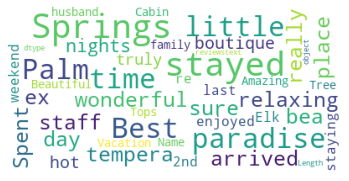

In [23]:
from subprocess import check_output
import numpy as np # linear algebra
import pandas as pd 
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
from wordcloud import WordCloud, STOPWORDS
mpl.rcParams['font.size']=12                #10 
mpl.rcParams['savefig.dpi']=100             #72 
mpl.rcParams['figure.subplot.bottom']=.1 
stopwords = set(STOPWORDS)

wordcloud = WordCloud(
                          background_color='white',
                          stopwords=stopwords,
                          max_words=200,
                          max_font_size=40, 
                          random_state=42
                         ).generate(str(data['reviewstext']))

print(wordcloud)
fig = plt.figure(1)
plt.imshow(wordcloud)
plt.axis('off')
plt.show()
fig.savefig("word1.png", dpi=900)

In [24]:
data = data.sort_values(by='reviewlen')
plt3 = go.Scatter(x = data.reviewlen, y = data.reviewsrating, mode='markers')
lyt3 = go.Layout(title="Review Length vs. Star Rating", xaxis=dict(title='Review Length'),yaxis=dict(title='Rating'))
fig3 = go.Figure(data=[plt3], layout=lyt3)
iplot(fig3)
print("Review Length to Rating Correlation:",data.reviewlen.corr(data.reviewsrating))

Review Length to Rating Correlation: -0.16046661519504807


In [36]:
!apt-get install -q libgeos-3.5.0
!apt-get install -q libgeos-dev
!pip install -q https://github.com/matplotlib/basemap/archive/master.zip

Reading package lists...
Building dependency tree...
Reading state information...
E: Unable to locate package libgeos-3.5.0
E: Couldn't find any package by glob 'libgeos-3.5.0'
E: Couldn't find any package by regex 'libgeos-3.5.0'
Reading package lists...
Building dependency tree...
Reading state information...
libgeos-dev is already the newest version (3.6.2-1build2).
libgeos-dev set to manually installed.
0 upgraded, 0 newly installed, 0 to remove and 37 not upgraded.
     - 133.1 MB 3.1 MB/s
     |████████████████████████████████| 6.3 MB 4.2 MB/s 
     |████████████████████████████████| 219 kB 67.0 MB/s 


In [37]:
!pip install -q pyproj==1.9.6
from mpl_toolkits.basemap import Basemap
import matplotlib.pyplot as plt
%matplotlib inline

     |████████████████████████████████| 2.8 MB 4.0 MB/s 


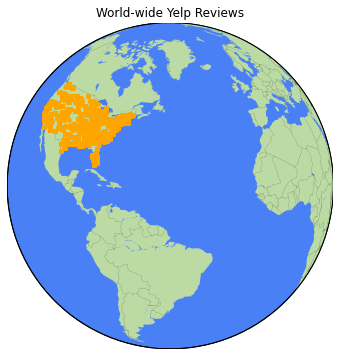

In [38]:

#basic basemap of the world
plt.figure(1, figsize=(15,6))
# use ortho projection for the globe type version
m1=Basemap(projection='ortho',lat_0=20,lon_0=-50)

# hex codes from google maps color pallete = http://www.color-hex.com/color-palette/9261
#add continents
m1.fillcontinents(color='#bbdaa4',lake_color='#4a80f5') 
# add the oceans
m1.drawmapboundary(fill_color='#4a80f5')                
# Draw the boundaries of the countires
m1.drawcountries(linewidth=0.1, color="black")

#Add the scatter points to indicate the locations of the businesses
mxy = m1(data["longitude"].tolist(), data["latitude"].tolist())
m1.scatter(mxy[0], mxy[1], s=3, c="orange", lw=3, alpha=1, zorder=5)
plt.title("World-wide Yelp Reviews")
plt.show()

In [25]:
#Setting up the X and Y data, where X is the review text and Y is the rating
#Three different inputs will be used: original review text, cleaned review text, and only adjectives review text
x1 = data.reviewstext
x2 = data.cleanrev
x3 = data.adjreview
y = data.reviewsrating

In [26]:
#Creating a vectorizer to split the text into unigrams and bigrams
vect = TfidfVectorizer(ngram_range = (1,2))
x_vect1 = vect.fit_transform(x1)
x_vect2 = vect.fit_transform(x2)
x_vect3 = vect.fit_transform(x3)

In [27]:
#Making some simple functions for linear svc, knn, and naive bayes
def linsvc(x,y):
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25, random_state = 10)
    classf = LinearSVC()
    classf.fit(x_train, y_train)
    pred = classf.predict(x_test)
    print("Linear SVC:",accuracy_score(y_test, pred))
    return(y_test, pred)

def revknn(x,y):
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25, random_state = 10)
    classf = KNeighborsClassifier(n_neighbors=2)
    classf.fit(x_train, y_train)
    pred = classf.predict(x_test)
    print("kNN:",accuracy_score(y_test, pred))
    return(y_test, pred)

def revnb(x,y):
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25, random_state = 10)
    classf = MultinomialNB()
    classf.fit(x_train, y_train)
    pred = classf.predict(x_test)
    print("Naive Bayes:",accuracy_score(y_test, pred))
    return(y_test, pred)

In [28]:
svmy1,svmp1 = linsvc(x_vect1,y)
svmy2,svmp2 = linsvc(x_vect2,y)
svmy3,svmp3 = linsvc(x_vect3,y)

knny1,knnp1 = revknn(x_vect1,y)
knny2,knnp2 = revknn(x_vect2,y)
knny3,knnp3 = revknn(x_vect3,y)

nby1,nbp1 = revnb(x_vect1,y)
nby2,nbp2 = revnb(x_vect2,y)
nby3,nbp3 = revnb(x_vect3,y)

Linear SVC: 0.5274232962259028
Linear SVC: 0.5196850393700787
Linear SVC: 0.44800434428455066
kNN: 0.11254412163996742
kNN: 0.11390171056204182
kNN: 0.20187347271246267
Naive Bayes: 0.4006244909041542
Naive Bayes: 0.40619060548465924
Naive Bayes: 0.42329622590279664


In [29]:
#This function will plot a confusion matrix and is taken from the sklearn documentation with just some minor tweaks
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = np.around((cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]),decimals=2)
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[ 429   94   78   50   76]
 [ 158  148  210  111   59]
 [  91   88  397  385  232]
 [  38   39  247  875  867]
 [  23   23   75  537 2036]]
Confusion matrix, without normalization
[[ 436   76   79   51   85]
 [ 150  141  214  115   66]
 [  98   93  372  366  264]
 [  47   36  206  872  905]
 [  21   22   86  558 2007]]
Confusion matrix, without normalization
[[  50    0   16  149  512]
 [   4    0   22  231  429]
 [   0    0   22  341  830]
 [   2    0    8  316 1740]
 [   2    0    1   87 2604]]


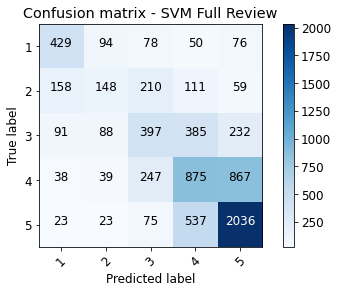

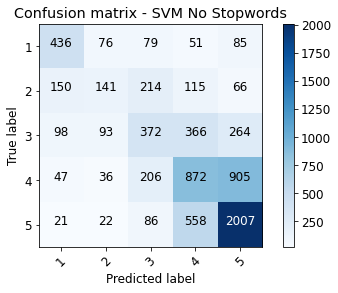

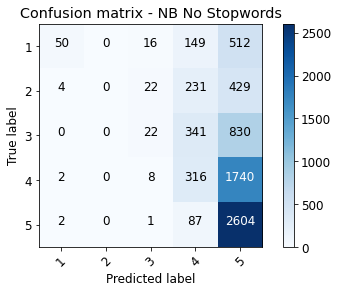

In [30]:
c1 = confusion_matrix(svmy1,svmp1)
c2 = confusion_matrix(svmy2,svmp2)
c3 = confusion_matrix(nby2,nbp2)
class_names = ['1', '2', '3', '4', '5']
plt.figure()
plot_confusion_matrix(c1, classes=class_names,normalize=False,title='Confusion matrix - SVM Full Review')
plt.figure()
plot_confusion_matrix(c2, classes=class_names,normalize=False,title='Confusion matrix - SVM No Stopwords')
plt.figure()
plot_confusion_matrix(c3, classes=class_names,normalize=False,title='Confusion matrix - NB No Stopwords')